<a href="https://colab.research.google.com/github/EkuDS1/twitter-user-locator/blob/main/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [ ]:
# Make sure gensim version is 4.x.x
!pip install gensim --upgrade
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

In [ ]:
import os
import shutil
from pathlib import Path
import csv

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from gensim.models import FastText # For getting trained word embeddings

# used for deep learning
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.regularizers import l1
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


# getting rid of Tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing
### Load Data
Defines function that load the data and returns it as tensors of latitude, longitude and all tweets for a twitter user. Also defines function that optimizes datasets.

In [ ]:
# Code for optimizing dataset performance
AUTOTUNE = tf.data.AUTOTUNE
def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Load file and return datasets for text and location and their combined training dataset
def loadData(data_path):
    df = pd.read_csv(data_path, delimiter='\t', encoding='utf-8', names=['user', 'lat', 'lon', 'text'],
                     quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    
    # Normalize coordinates so that mean is 0 and std is 1
    # df[['lat', 'lon']] = (df[['lat', 'lon']]-df[['lat', 'lon']].mean())/df[['lat', 'lon']].std()

    # Get latitude, longitude and tweets separately
    lat = df['lat']
    lon = df ['lon']
    text = df ['text']
    
    # Remove ||| separator and replace with space
    text = text.str.lstrip(" |")
    text = text.str.replace(" \|\|\| ", " ", regex=True)
    
    # Convert all to tensor and return
    lat = tf.convert_to_tensor(lat)
    lon = tf.convert_to_tensor(lon)
    text = tf.convert_to_tensor(text)
    
    # Convert to text dataset and location dataset respectively
    text_ds = tf.data.Dataset.from_tensor_slices(text)
    location_ds = tf.data.Dataset.from_tensor_slices((lat, lon))
    trainingData = tf.data.Dataset.zip((text_ds, location_ds))

    # Configure datasets for performance
    text_ds = configure_dataset(text_ds)
    location_ds = configure_dataset(location_ds)
    trainingData = configure_dataset(trainingData)
    
    # Return datasets
    return text_ds, location_ds, trainingData

Tensors are then turned into datasets that can be split into batches.

In [ ]:
current_dir = Path('/content/drive/My Drive/')
data_path = current_dir / 'geoworld/user_info.dev'
output_path = current_dir / 'dev_output'
embeddings_path = output_path / 'embeddings-dev.model'

# Get datasets from data file
text_ds, location_ds, trainingData = loadData(data_path)

### BERT Model

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# Create Model

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    out_lat = tf.keras.layers.Dense(1, activation=None, name='latitude')(net)
    out_lon = tf.keras.layers.Dense(1, activation=None, name='longitude')(net)
    return tf.keras.Model(text_input, [out_lat, out_lon])



def tilted_loss(y,f):
    q = 0.5
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

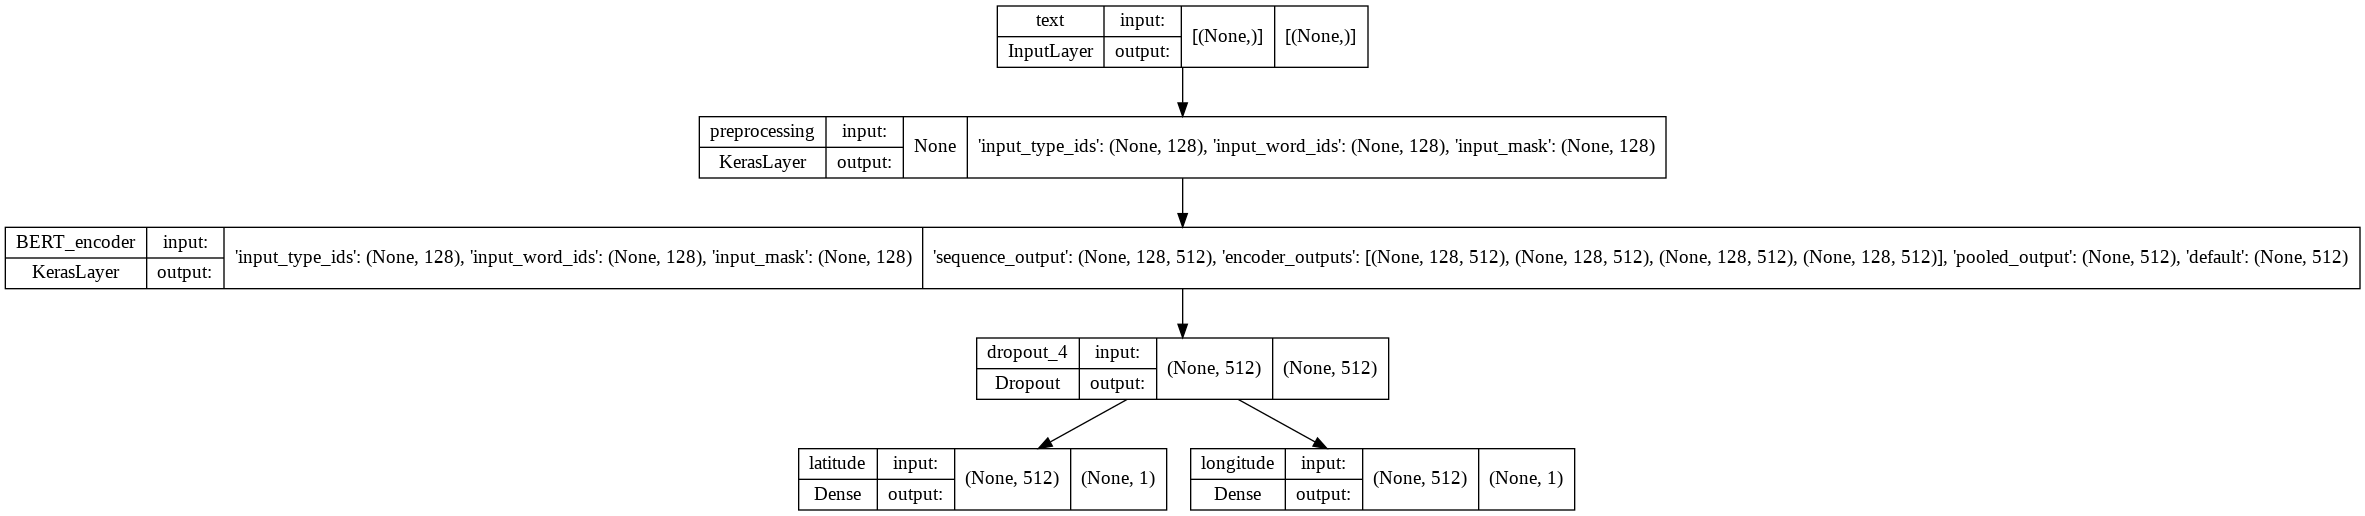

In [ ]:
# Make model
classifier_model = build_classifier_model()

loss = tilted_loss
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(trainingData).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer, loss=loss)

classifier_model.summary()
tf.keras.utils.plot_model(classifier_model, "multi_input_and_output_model.png", show_shapes=True)

# Train Model

In [ ]:
batch_size = 32

history = classifier_model.fit(x=trainingData.batch(batch_size),
                               epochs=10)

Epoch 1/10
313/313 [==============================] - 53s 169ms/step - loss: 40.2315 - latitude_loss: 7.5002 - longitude_loss: 32.7312
Epoch 2/10
313/313 [==============================] - 52s 168ms/step - loss: 39.1444 - latitude_loss: 7.1338 - longitude_loss: 32.0106
Epoch 3/10
313/313 [==============================] - 53s 169ms/step - loss: 37.9213 - latitude_loss: 6.7534 - longitude_loss: 31.1679
Epoch 4/10
313/313 [==============================] - 53s 168ms/step - loss: 36.6732 - latitude_loss: 6.4009 - longitude_loss: 30.2724
Epoch 5/10
313/313 [==============================] - 52s 166ms/step - loss: 35.3247 - latitude_loss: 6.0501 - longitude_loss: 29.2745
Epoch 6/10
313/313 [==============================] - 52s 165ms/step - loss: 33.9896 - latitude_loss: 5.7792 - longitude_loss: 28.2104
Epoch 7/10
313/313 [==============================] - 52s 166ms/step - loss: 32.5516 - latitude_loss: 5.4544 - longitude_loss: 27.0971
Epoch 8/10
313/313 [==============================] - 5

## Evaluate on Dev set

In [ ]:
# get dev set
data_path = current_dir / Path('geoworld/user_info.dev')

# Get datasets from dev file
text_ds_test, location_ds_test, testData = loadData(data_path)

classifier_model.evaluate(testData.batch(100))

100/100 [==============================] - 56s 552ms/step - loss: 26.8162 - latitude_loss: 4.3262 - longitude_loss: 22.4901


[26.816238403320312, 4.326155662536621, 22.490083694458008]

## Evaluate on Test set

In [ ]:
# get test set
data_path = current_dir / Path('geoworld/user_info.test')

# Get datasets from test file
text_ds_test, location_ds_test, testData = loadData(data_path)
  
classifier_model.evaluate(testData.batch(100))

100/100 [==============================] - 50s 499ms/step - loss: 29.9061 - latitude_loss: 5.0921 - longitude_loss: 24.8140


[29.906147003173828, 5.092135906219482, 24.81401252746582]

## Check Predictions

Check predictions for the first 20 samples in the training set.

In [ ]:
for item in trainingData.batch(1).take(20):
  print(item[1][0].numpy(), item[1][1].numpy())

[29.76328] [-95.36327]
[32.29876] [-90.18481]
[39.17316] [-77.27165]
[51.51279] [-0.09184]
[38.58157] [-121.4944]
[-2.91673] [104.7458]
[-0.8917] [119.8707]
[39.04372] [-77.48749]
[39.29038] [-76.61219]
[44.97997] [-93.26384]
[30.26715] [-97.74306]
[30.69436] [-88.04305]
[44.97997] [-93.26384]
[39.70471] [-105.08137]
[47.65966] [-117.42908]
[-1.45583] [-48.50444]
[-3.32442] [114.591]
[30.69436] [-88.04305]
[34.00071] [-81.03481]
[55.86515] [-4.25763]


In [ ]:
pred = classifier_model.predict(trainingData.batch(1).take(20))

In [ ]:
for i in range(len(pred[0])):
  print(pred[0][i], pred[1][i])

[34.67296] [-38.060333]
[34.25962] [-38.167458]
[35.619205] [-37.59237]
[35.943703] [-2.3333967]
[34.43249] [-38.128662]
[-5.21128] [36.630085]
[-3.0780537] [35.762787]
[34.759457] [-38.034874]
[34.500736] [-38.11055]
[34.837944] [-38.000164]
[34.48049] [-38.115856]
[34.51208] [-38.10678]
[34.40801] [-38.12793]
[38.61683] [-11.789956]
[35.664658] [-37.566334]
[-2.8026283] [-32.344925]
[-5.9863973] [36.859543]
[35.339996] [-37.78062]
[34.61176] [-38.08063]
[36.682903] [-3.686323]


## How many within 100 miles?

Calculate what percentage of predictions are within 100 miles of their actual location.

In [ ]:
def haversine_km(lat1, lon1, lat2, lon2):
  R = 6372.795
  dlat = math.radians(lat2-lat1)
  dlon = math.radians(lon2-lon1)
  a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  return R * c

pred = model.predict(testData.batch(100))